cambios que hice:
- modifiqué algunos de los parámetros
- desusé la def boltzmann(V, V_half, k) porque no sabía si jalaba,
  la saqué para irla testeando, y como jaló ya no la regresé
- dejé pendiente encuadrar bien las ceroclinas y el ciclo para ver las curvas de la ceroclina de V
- puse una diferencia entre:

V_half_n = -40
kn = 6
V_half_m = -20
km = 16

por eso saqué tu función de boltzmann


<h4 style="color: #800080;"> MODELO HODKING & HUXLEY SISTEMA NO LINEAL </h4>

#### Introducción al sistema. 
El modelo planteado para 

$\textbf{El potencial de membrana:}$
\begin{eqnarray}
\frac{dV}{dt} = \frac{I_{inyec} - \bar{g}_l(V-E_l) - \bar{g}_{Na} m_{\infty}(V) (V-E_{Na}) - \bar{g}_K n (V-E_K)}{C_m }\\
\end{eqnarray}
$\textbf{El cambio en la aactivación de los canales de potasio:}$
\begin{eqnarray}
\frac{dn}{dt} = \frac{n_{\infty}(V) - n}{\tau_n}\\
\end{eqnarray}



In [56]:
import numpy as np
import matplotlib.pylab as gr
import sympy as sm
import matplotlib.patches as mpatches

<h4 style="color: magenta;"> Definición de los métodos numéricos cómo función RK4</h4>

In [57]:
    # Definir la función numérica RK4 que contiene las cond. iniciales ic, la función f que define al sistema de EDOs y de un
    # diccionario que contiene los parámetros p de la simulación.
def RK4vec(ic, f, p):    
    # Crear un array que representa los puntos en el tiempo con un tamaño de paso h
    t = np.arange(p['tinit'], p['tfinal'], p['h']) 
    # Crear la matriz de solución U donde cada fila representa un instante de tiempo y cada columna una variable del sistema
    U = np.zeros((len(t), len(ic)))   # U es un vector de dos elementos
    # Establecer condiciones iniciales para la primera fila t[0] 
    U[0] = ic

    # Calcular para las demás filas definiendo RK4 cómo se vió en clase
    for i in range(1,len(t)):
        k1 = f(U[i-1])*p['h']
        k2 = f(U[i-1]+k1/2)*p['h']
        k3 = f(U[i-1]+k2/2)*p['h']
        k4 = f(U[i-1]+k3)*p['h']
        U[i] = U[i-1]+(k1+2*k2+2*k3+k4)/6
        
    # Se transpone la matriz para que cada fila corresponda a una variable y cada columna a un instante de tiempo
    return U.transpose()

<h4 style="color: magenta;"> Diccionario</h4>

In [58]:
# 1. Definición de Parámetros y Funciones Auxiliares
q_neuro = {
    'C_m': 1.0,
    'g_L': 8, #0.3,   
    'E_L': -80, #-54.4, # potencial de reposo recalibrado
    'g_Na': 20, #120.0, 
    'E_Na': 60, # 50.0,
    'g_K': 10, #36.0,  
    'E_K': -100, # -77.0,
    'I_inyec': 4.8, #10.0, 

    # INACTIVACIÓN 
    'Vm': -40.0,  # mV voltaje medio de inactivación del sodio
    'kn': -6.0,  # mV inactivación del sodio
    'tau_n': 5.0, # constante de tiempo para generar histéresis 
    
    # Parámetros para el sodio rápido (m)
    'Vm_m': -40.0, 
    'km': -6.0,
    
    # Configuración de simulación RK4
    'h': 0.05,
    'tinit': 0,
    'tfinal': 60
}

V_half_n = -40
kn = 6
V_half_m = -20
km = 16

<h4 style = "color: rgb(0, 128, 0);">Definición de la función F(x) a estudiar</h4>

In [59]:
# Función Sigmoide de Boltzmann
def sigmoide_vec(V, V_half, k):
    return 1.0 / (1.0 + np.exp((V_half - V) / k))

# Sistema de Ecuaciones
def modelo_neurona(U):
    V, n = U
    
    m_val = 1.0 / (1.0 + np.exp((V_half_m - V) / km))
    n_inf_val = 1.0 / (1.0 + np.exp((V_half_n - V) / kn))
    dn = (n_inf_val - n) / q_neuro['tau_n']

    # Corrientes
    I_L = q_neuro['g_L'] * (V - q_neuro['E_L'])
    I_Na = q_neuro['g_Na'] * m_val * (V - q_neuro['E_Na'])
    I_K = q_neuro['g_K'] * n * (V - q_neuro['E_K']) 
    dV = (q_neuro['I_inyec'] - I_L - I_Na - I_K) / q_neuro['C_m']
    
    return np.array([dV, dn])

<h4 style="color: #FF0000;">Gráfica de soluciones vs tiempo con UNA condición inical</h4>

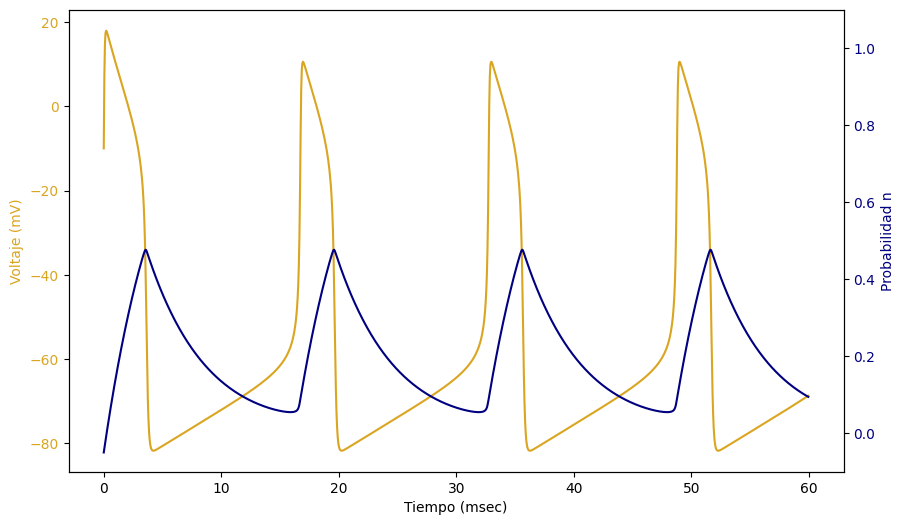

In [60]:
# Una vez definidos los elementos de RK4, se podrá calcular la trayectoria del sistema a través de orbit
orbit = RK4vec([-10, -0.05], modelo_neurona, q_neuro)  # Establecer condiciones iniciales
x_orbit, y_orbit = orbit                    # Definir matriz de evolución completa de 2x1,000
t = np.arange(q_neuro["tinit"],q_neuro["tfinal"],q_neuro["h"])

# 5. Código de Gráfica Corregido con Nuevos Colores
fig, ax1 = gr.subplots(figsize=(10, 6))

# Eje izquierdo para Voltaje (V) - DORADO
color_v = 'goldenrod'
line_v, = ax1.plot(t, x_orbit, color=color_v, label='Voltaje (mV)')
ax1.set_ylabel('Voltaje (mV)', color=color_v)
ax1.tick_params(axis='y', labelcolor=color_v)
ax1.set_xlabel('Tiempo (msec)')

# Eje derecho para n (Variable de Recuperación) - AZUL MARINO
color_n = 'navy'
ax2 = ax1.twinx()
line_n, = ax2.plot(t, y_orbit, color=color_n, label='Variable n')
ax2.set_ylabel('Probabilidad n', color=color_n)
ax2.set_ylim(-0.1, 1.1) 
ax2.tick_params(axis='y', labelcolor=color_n)

Explicación

<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
C:\Users\End User\AppData\Local\Temp\ipykernel_30832\1478124613.py:42: SyntaxWarning: invalid escape sequence '\d'
  gr.plot(v_plot, V_nullcline(v_plot), 'b--', linewidth=2, label='Ceroclina V ($\dot{V}=0$)')
C:\Users\End User\AppData\Local\Temp\ipykernel_30832\1478124613.py:43: SyntaxWarning: invalid escape sequence '\d'
  gr.plot(v_plot, n_nullcline(v_plot), 'r-', linewidth=2, label='Ceroclina n ($\dot{n}=0$)')


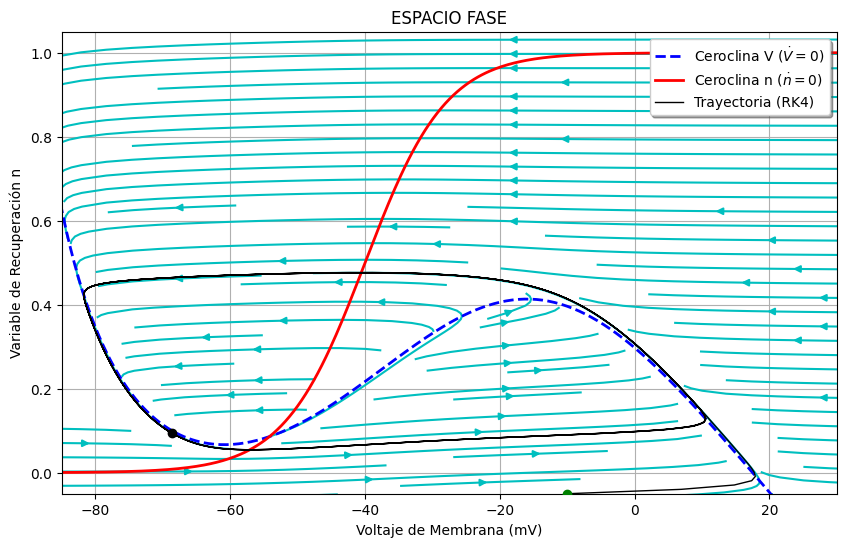

In [61]:
# Intervalos para el campo y nuclinas
v_interval = np.arange(-90.0, 50.0, 2.0) 
n_interval = np.arange(-0.1, 1.1, 0.1)
V_mesh, n_mesh = np.meshgrid(v_interval, n_interval) # mallado

# Componentes del sistema no lineal
m_inf_mesh = sigmoide_vec(V_mesh, V_half_m, km)
n_inf_mesh = sigmoide_vec(V_mesh, V_half_n, kn)
I_L_mesh = q_neuro['g_L'] * (V_mesh - q_neuro['E_L'])
I_Na_mesh = q_neuro['g_Na'] * m_inf_mesh * (V_mesh - q_neuro['E_Na'])
I_K_mesh = q_neuro['g_K'] * n_mesh * (V_mesh - q_neuro['E_K'])

# Sistema no lineal
dV_dt = (q_neuro['I_inyec'] - I_L_mesh - I_Na_mesh - I_K_mesh) / q_neuro['C_m']
dn_dt = (n_inf_mesh - n_mesh) / q_neuro['tau_n']


# Ceroclinas del sistema
def V_nullcline(V_arr): 
    m_val = sigmoide_vec(V_arr, V_half_m, km)
    num = q_neuro['I_inyec'] - q_neuro['g_L']*(V_arr - q_neuro['E_L']) - q_neuro['g_Na']*m_val*(V_arr - q_neuro['E_Na'])
    den = q_neuro['g_K'] * (V_arr - q_neuro['E_K'])
    return num / den

def n_nullcline(V_arr): 
    return sigmoide_vec(V_arr, V_half_n, kn)
    
# --- Grafica del espacio fase ---
gr.figure(figsize=(10, 6))
gr.title('ESPACIO FASE')
gr.xlabel('Voltaje de Membrana (mV)')
gr.ylabel('Variable de Recuperación n')

#  Campo de Direcciones (flujo del sistema)
gr.streamplot(V_mesh, n_mesh, dV_dt, dn_dt, color='c', density=1.2)

#  Intersección de ceroclinas (punto fijo)
## el pf se calcula analíticamente

# Ceroclinas
v_plot = np.linspace(-90, 60, 500)
gr.plot(v_plot, V_nullcline(v_plot), 'b--', linewidth=2, label='Ceroclina V ($\dot{V}=0$)')
gr.plot(v_plot, n_nullcline(v_plot), 'r-', linewidth=2, label='Ceroclina n ($\dot{n}=0$)')

# Trayectoria numérica (solución RK4)
gr.plot(x_orbit, y_orbit, 'k', linewidth=1.0, label='Trayectoria (RK4)')
gr.plot(x_orbit[0], y_orbit[0], 'go', zorder=5) # Punto inicio
gr.plot(x_orbit[-1], y_orbit[-1], 'ko', zorder=5) # Punto final

# Ajustes
gr.axis([-85, 30, -0.05, 1.05])
gr.legend(loc='upper right', shadow=True)
gr.grid(True)
gr.show()

Explicación
hola

In [62]:
V, n = sm.symbols('V n', real=True)

# 2. Definición de constantes (Diccionario proporcionado)
q_neuro = {
    'C_m': 1.0,
    'g_L': 8,
    'E_L': -80,
    'g_Na': 20,
    'E_Na': 60,
    'g_K': 10,
    'E_K': -100,
    'I_inyec': 4.8,
    'Vm': -40.0,   # voltaje medio n
    'kn': -6.0,    # pendiente n
    'tau_n': 5.0,
    'Vm_m': -40.0, # voltaje medio m
    'km': -6.0,    # pendiente m

    # Configuración de simulación RK4
    'h': 0.05,
    'tinit': 0,
    'tfinal': 60
}

# 3. Funciones Auxiliares (Sigmoides)
m_inf = 1 / (1 + sm.exp((V - q_neuro['Vm_m']) / q_neuro['km']))
n_inf = 1 / (1 + sm.exp((V - q_neuro['Vm']) / q_neuro['kn']))

# 4. Definición del Sistema de Ecuaciones Diferenciales
dV = (
    q_neuro['I_inyec']
    - q_neuro['g_L'] * (V - q_neuro['E_L'])
    - q_neuro['g_Na'] * m_inf * (V - q_neuro['E_Na'])
    - q_neuro['g_K'] * n * (V - q_neuro['E_K'])
) / q_neuro['C_m']

dn = (n_inf - n) / q_neuro['tau_n']


In [63]:
dV

-8.0*V - 10.0*n*(V + 100) - 635.2 - 20.0*(V - 60)/(1 + 0.00127263380133981*exp(-0.166666666666667*V))

In [64]:
dn

-0.2*n + 0.2/(1 + 0.00127263380133981*exp(-0.166666666666667*V))

In [65]:
sm.solve(dV,n)

[0.16*(-1.75e+18*V*exp(0.166666666666667*V) - 636316900669905.0*V + 3.53e+19*exp(0.166666666666667*V) - 5.05235619131905e+16)/(1.0e+17*V*exp(0.166666666666667*V) + 127263380133981.0*V + 1.0e+19*exp(0.166666666666667*V) + 1.27263380133981e+16)]

In [66]:
sm.solve(dn,n)

[1.0e+17*exp(0.166666666666667*V)/(1.0e+17*exp(0.166666666666667*V) + 127263380133981.0)]

In [67]:
# Encontrar ceroclinas
vnull = sm.solve(dV,n)
vNullcline = sm.lambdify(V,vnull)
nnull = sm.solve(dn,n)
nNullcline = sm.lambdify(V,nnull)

In [68]:
# Rango de Voltaje (Eje X): De -110 mV a 70 mV para ver todo el ciclo
xl = np.linspace(-110, 70, 200)
# Rango de Activación n (Eje Y): De -0.1 a 1.1 
yl = np.linspace(-0.1, 1.1, 200)
X,Y = np.meshgrid(xl,yl)

In [69]:
xq = (
    q_neuro['I_inyec']
    - q_neuro['g_L'] * (V - q_neuro['E_L'])
    - q_neuro['g_Na'] * m_inf * (V - q_neuro['E_Na'])
    - q_neuro['g_K'] * n * (V - q_neuro['E_K'])
) / q_neuro['C_m']
yq = (n_inf - n) / q_neuro['tau_n']

# Rangos lógicos para una neurona: V (-100 a 50 mV), n (0 a 1)
x_interval = np.linspace(-100, 50, 100)  # Voltaje
y_interval = np.linspace(-0.1, 1.1, 100) # Variable n

X, Y = np.meshgrid(x_interval, y_interval)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\End User\AppData\Local\Temp\ipykernel_30832\880794108.py:8: SyntaxWarning: invalid escape sequence '\d'
  gr.plot(x_interval, vNullcline_func(x_interval), color='navy', linewidth=2, label='Ceroclina V ($\dot{V}=0$)')
C:\Users\End User\AppData\Local\Temp\ipykernel_30832\880794108.py:9: SyntaxWarning: invalid escape sequence '\d'
  gr.plot(x_interval, nNullcline_func(x_interval), color='red', linewidth=2, label='Ceroclina n ($\dot{n}=0$)')
<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.16*(-1.75e+18*V*exp(0.166666666666667*V) - 636316900669905.0*V + 3.53e+19*exp(0.166666666666667*V) - 5.05235619131905e+16)/(1.0e+17*V*exp(0.166666666666667*V) + 127263380133981.0*V + 1.0e+19*exp(0.166666666666667*V) + 1.27263380133981e+16)


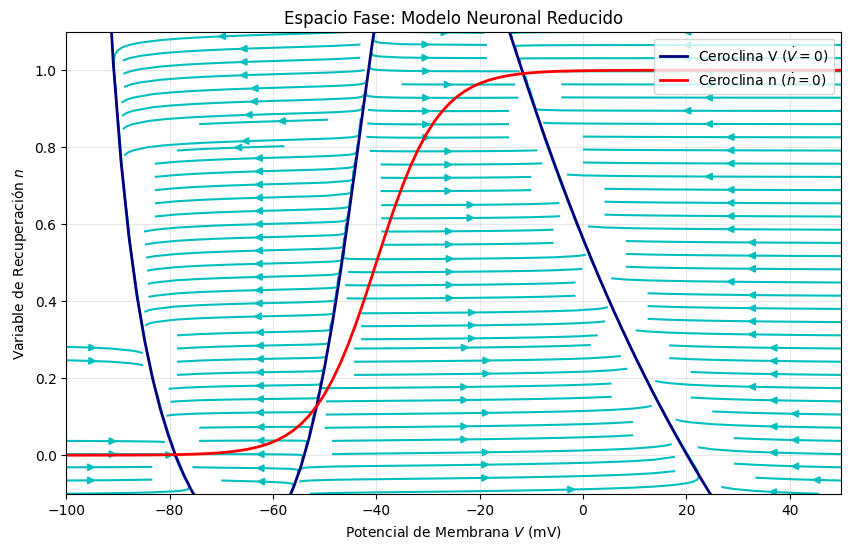

In [70]:
xq = dV_func(X, Y)
yq = dn_func(X, Y)

# --- 3. Gráfica ---
fig, H = gr.subplots(1, 1, figsize=(10, 6))

gr.streamplot(X, Y, xq, yq, color='c', density=1.2, arrowsize=1)
gr.plot(x_interval, vNullcline_func(x_interval), color='navy', linewidth=2, label='Ceroclina V ($\dot{V}=0$)')
gr.plot(x_interval, nNullcline_func(x_interval), color='red', linewidth=2, label='Ceroclina n ($\dot{n}=0$)')

H.set_title('Espacio Fase: Modelo Neuronal Reducido')
H.set_xlabel('Potencial de Membrana $V$ (mV)')
H.set_ylabel('Variable de Recuperación $n$')
H.legend(loc='upper right')
H.grid(True, alpha=0.3)
H.set_ylim(-0.1, 1.1) 
H.set_xlim(-100, 50)   
gr.show()

In [71]:
def ClasificadorNeuronal(Equilibrio):
    """
    Analiza la estabilidad de un punto de equilibrio (V_eq, n_eq) 
    para el sistema neuronal reducido.
    """
    
    # 1. Matriz Jacobiana (Usando V y n)
    eqMat = sm.Matrix([dV, dn])
    Mat = sm.Matrix([V, n])
    jacMat = eqMat.jacobian(Mat)
    
    # 2. Evaluación en el Punto de Equilibrio
    # Sustituimos V por Equilibrio[0] y n por Equilibrio[1]
    jac_eval = jacMat.subs([(V, Equilibrio[0]), (n, Equilibrio[1])])
    
    # 3. Cálculo de Valores Propios, Traza y Determinante
    # eigenvals devuelve {valor: multiplicidad}
    eigen_dict = jac_eval.eigenvals()
    eige = list(eigen_dict.keys())
    
    traz = jac_eval.trace()
    deter = jac_eval.det()
    Delta = traz**2 - 4*deter
    
    print(f"\n--- Análisis del Punto Fijo: V={Equilibrio[0]:.2f} mV, n={Equilibrio[1]:.2f} ---")
    # print(f"Jacobiana Evaluada:\n{jac_eval}")
    
    # 4. Eigenvalores
    if len(eige) == 1:
        l1 = complex(eige[0])
        print(f"Eigenvalor degenerado (multiplicidad {eigen_dict[eige[0]]}): {l1:.4f}")
    else:
        l1 = complex(eige[0])
        l2 = complex(eige[1])
        print(f"Eigenvalores: {l1:.4f} y {l2:.4f}")

    # 5. Clasificación de Estabilidad (Tu lógica adaptada)
    # Nota: Usamos evaluación numérica de traza y determinante para las comparaciones
    
    tr_val = float(traz)
    det_val = float(deter)
    delta_val = float(Delta)

    stability_msg = "Indeterminado"
    marker = 'ko'
    
    if abs(tr_val) < 1e-9: # Traza cero (o muy cercana)
        if det_val > 0:
            stability_msg = 'Centro (Oscilaciones neutras)'
            marker = 'y.'
        elif det_val < 0:
            stability_msg = 'Punto Silla (Saddle Node)'
            marker = 'r.'
        else:
            stability_msg = 'Degenerado (Determinante 0)'
            
    elif tr_val < 0: # Traza Negativa -> ESTABLE
        if det_val > 0:
            if delta_val < 0:
                stability_msg = 'Foco/Espiral ESTABLE (Atractor)'
                marker = 'ko' # Negro solido
            elif delta_val > 0:
                stability_msg = 'Nodo ESTABLE (Atractor)'
                marker = 'bo' # Azul solido
            else:
                stability_msg = 'Nodo Degenerado ESTABLE'
                marker = 'bv'
        elif det_val < 0:
            stability_msg = 'Punto Silla (Saddle Node) - Inestable'
            marker = 'rx'
        else:
            stability_msg = 'Línea de puntos estables (Det=0)'
            
    else: # Traza Positiva -> INESTABLE
        if det_val > 0:
            if delta_val < 0:
                stability_msg = 'Foco/Espiral INESTABLE (Repulsor)'
                marker = 'wo' # Blanco/hueco
            elif delta_val > 0:
                stability_msg = 'Nodo INESTABLE (Repulsor)'
                marker = 'ro' # Rojo hueco
            else:
                stability_msg = 'Nodo Degenerado INESTABLE'
        elif det_val < 0:
            stability_msg = 'Punto Silla (Saddle Node) - Inestable'
            marker = 'rx'
        else:
            stability_msg = 'Línea de puntos inestables'

    print(f"Clasificación: {stability_msg}")
    return stability_msg

In [72]:
solucion_matriz = sm.nsolve((V_Equal, n_Equal), (V, n), (-60, 0.1))
    
# Convertimos el resultado de Matriz SymPy a una lista simple de floats [V, n]
Equilibrio = [float(solucion_matriz[0]), float(solucion_matriz[1])]

print(f"Punto de Equilibrio encontrado: {Equilibrio}")
ClasificadorNeuronal(Equilibrio)

Punto de Equilibrio encontrado: [-52.02852485205648, 0.11870467056168332]

--- Análisis del Punto Fijo: V=-52.03 mV, n=0.12 ---
Eigenvalores: 27.4441+0.0000j y -0.1395+0.0000j
Clasificación: Punto Silla (Saddle Node) - Inestable


'Punto Silla (Saddle Node) - Inestable'

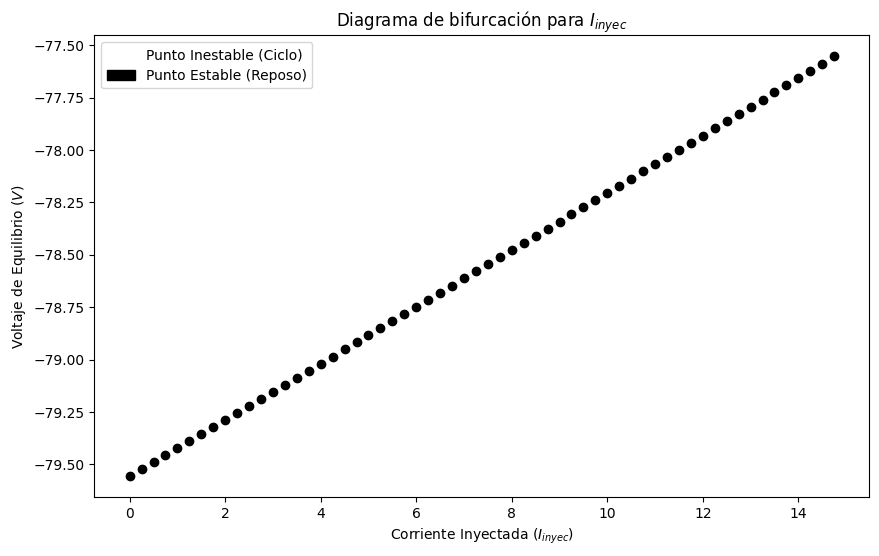

In [73]:
markercolor = []
facecolor = []
gr.figure(figsize=(10, 6))

arango = np.arange(0, 15, 0.25)  # Rango de corriente
guess = (-65, 0.1) # Necesario para nsolve

for i in range(len(arango)):
    # 1. Actualizar parámetro en el diccionario correcto
    q_neuro['I_inyec'] = arango[i]
    
    # 2. Crear símbolos
    V, n = sm.symbols('V n', real=True)
    
    # 3. Redefinir funciones auxiliares con los NUEVOS símbolos V y n
    m_inf = 1 / (1 + sm.exp((V - q_neuro['Vm_m']) / q_neuro['km']))
    n_inf = 1 / (1 + sm.exp((V - q_neuro['Vm']) / q_neuro['kn']))
    
    # 4. Ecuaciones (Asignadas a dV y dn)
    dV = (q_neuro['I_inyec']
          - q_neuro['g_L'] * (V - q_neuro['E_L'])
          - q_neuro['g_Na'] * m_inf * (V - q_neuro['E_Na'])
          - q_neuro['g_K'] * n * (V - q_neuro['E_K'])
          ) / q_neuro['C_m']

    dn = (n_inf - n) / q_neuro['tau_n']
    
    # 5. Igualdades
    V_Equal = sm.Eq(dV, 0)
    n_Equal = sm.Eq(dn, 0)
    
    # 6. Solución Numérica (nsolve)
    equilibrio_matriz = sm.nsolve((V_Equal, n_Equal), (V, n), guess)
    Equilibrio = [float(equilibrio_matriz[0]), float(equilibrio_matriz[1])]
    guess = tuple(Equilibrio)
    Clasificador_Neuronal(Equilibrio, dV, dn) 
    gr.plot(arango[i], Equilibrio[0], marker='o', 
            color=markercolor[i], markerfacecolor=facecolor[i])

# Leyendas
blue_patch = mpatches.Patch(color='white', label='Punto Inestable (Ciclo)')
black_patch = mpatches.Patch(color='black', label='Punto Estable (Reposo)')
gr.legend(handles=[blue_patch, black_patch])
gr.xlabel('Corriente Inyectada ($I_{inyec}$)')
gr.ylabel('Voltaje de Equilibrio ($V$)')
gr.title('Diagrama de bifurcación para $I_{inyec}$')
gr.show()